In [13]:
# Mount Google Drive (optional, if you need to save/load data)
from google.colab import drive
drive.mount('/content/drive')

# Define file path
f_path = '/content/drive/MyDrive/DiTing2.0/'

!pip install deepwave

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 49.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━ 149.1/363.4 MB 46.6 MB/s eta 0:00:05
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [14]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import datetime

import pickle
import numpy as np

f_path = '/content/drive/MyDrive/DiTing2.0/'


In [15]:
#@title Generate random velocity model

class SeismicConfig:
    """Configuration class for seismic modeling"""
    def __init__(
        self,
        model_dims=(300,300,300),
        v0: float = 1500.0,  # Background velocity
        v_min: float = 1500.0,  # Minimum velocity
        v_max: float = 4500.0,  # Maximum velocity
        dv: float = 500.0,  # Velocity variation
    ):
        self.model_dims = model_dims
        self.v0 = v0
        self.v_min = v_min
        self.v_max = v_max
        self.dv = dv

def create_velocity_model(
    cfg: SeismicConfig,
    device: torch.device,
    seed: int = None):
    """
    Generates 3D velocity model with realistic geological features

    Features:
    - Horizon layers with natural undulations
    - Curved layers with varying thickness
    - Complex salt bodies

    Args:
        cfg: Configuration object containing model parameters
        device: Computation device (CPU/GPU)
        seed: Random seed for reproducibility (default: None)

    Returns:
        3D velocity tensor with shape (nx, ny, nz)
    """
    # Set random seed if provided
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)

    nx, ny, nz = cfg.model_dims

    # Initialize base velocity model
    velocity = torch.full(cfg.model_dims, cfg.v0, device=device)

    # Create coordinate grids
    X, Y, Z = torch.meshgrid(
        torch.arange(nx, device=device),
        torch.arange(ny, device=device),
        torch.arange(nz, device=device),
        indexing='ij'
    )

    # Generate horizon layers with undulations
    num_layers = torch.randint(4, 8, (1,)).item()
    for i in range(num_layers):
        # Layer depth function with undulations
        depth_base = (i + 1) * nz // (num_layers + 1)

        # Add undulations using combination of sine waves
        undulation = (
            10 * torch.sin(2 * np.pi * X[:,:,0] / nx * torch.rand(1, device=device)) +
            10 * torch.cos(2 * np.pi * Y[:,:,0] / ny * torch.rand(1, device=device)) +
            5 * torch.sin(4 * np.pi * (X[:,:,0] + Y[:,:,0]) / (nx + ny))
        )

        # Add curved component
        curve = 0.1 * ((X[:,:,0] - nx/2)**2 + (Y[:,:,0] - ny/2)**2) / (nx * ny)

        # Create layer depth map (2D)
        layer_depth = depth_base + undulation + curve

        # Create 3D layer mask
        base_vel = 2000 + i * 200 + torch.randn(1, device=device) * 100

        for i_x in range(nx):
            for i_y in range(ny):
                depth = int(layer_depth[i_x, i_y].item())
                if depth < nz:  # Ensure depth is within bounds
                    velocity[i_x, i_y, depth:] = base_vel

    # Add salt bodies with complex shapes
    num_salt = torch.randint(1, 3, (1,)).item()
    for _ in range(num_salt):
        # Salt body center and dimensions
        x0 = torch.randint(nx//4, 3*nx//4, (1,), device=device).item()
        y0 = torch.randint(ny//4, 3*ny//4, (1,), device=device).item()
        z0 = torch.randint(nz//3, 2*nz//3, (1,), device=device).item()

        rx = torch.randint(10, max(11, nx//5), (1,), device=device).item()
        ry = torch.randint(10, max(11, ny//5), (1,), device=device).item()
        rz = torch.randint(10, max(11, nz//5), (1,), device=device).item()

        # Create salt body with basic ellipsoidal shape
        salt_mask = ((X - x0)**2/rx**2 + (Y - y0)**2/ry**2 + (Z - z0)**2/rz**2) < 1.0

        # Set salt velocity (typically around 4500 m/s)
        velocity[salt_mask] = 4500 + torch.randn(1, device=device) * 100

    # Ensure velocity is within realistic bounds
    return torch.clamp(velocity, cfg.v_min, cfg.v_max)



# Create configuration
cfg = SeismicConfig(
    model_dims=(300, 300, 300),
    v0=1500.0,
    v_min=1500.0,
    v_max=4500.0,
    dv=500.0
)

# Generate velocity model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# velocity_model = create_velocity_model(cfg, device, 0) # [128,128,128]


In [16]:
#@title Convert Velocity Model to Rock Types/Density
import numpy as np
from scipy.ndimage import gaussian_filter

def velocity_to_density(velocity):
    """Convert velocity to density using empirical relationships like Gardner's equation"""
    # Gardner's equation: ρ = a * v^b
    # where a=0.31, b=0.25 when v is in m/s and ρ in g/cm³
    a = 0.31
    b = 0.25
    return a * (velocity ** b)

def density_to_susceptibility(density, random_factor=0.2):
    """
    Convert density to magnetic susceptibility using a simplified relationship
    with some randomness to simulate natural variations.
    Works with both NumPy arrays and PyTorch tensors.
    """
    # Check if input is a PyTorch tensor
    is_torch = torch.is_tensor(density)

    # Create base susceptibility - higher density often correlates with higher susceptibility
    base_susceptibility = (density - 2.0) * 0.001  # Simplified relationship
    # print(f'base_susceptibility={base_susceptibility}')

    # Add geological noise to make it more realistic
    if is_torch:
        # PyTorch version
        mean_value = torch.mean(base_susceptibility).item()
        std_dev = random_factor * mean_value
        random_noise = torch.normal(0, std_dev, base_susceptibility.shape, device=density.device)
        susceptibility = base_susceptibility + random_noise
        # Ensure no negative susceptibilities (non-physical)
        susceptibility = torch.clamp(susceptibility, min=0)
    else:
        # NumPy version
        mean_value = np.mean(base_susceptibility)
        random_noise = np.random.normal(0, random_factor * mean_value, base_susceptibility.shape)
        susceptibility = base_susceptibility + random_noise
        # Ensure no negative susceptibilities (non-physical)
        susceptibility = np.maximum(susceptibility, 0)

    return susceptibility


def add_geological_features(susceptibility_model, n_features=5):
    """Add geological features like intrusions or ore bodies using PyTorch operations"""
    model = susceptibility_model.clone()
    shape = model.shape
    device = model.device

    for _ in range(n_features):
        # Random center point for the anomaly
        center = torch.tensor([torch.randint(0, dim, (1,)).item() for dim in shape],
                             device=device)

        # Random size for the anomaly
        size = torch.randint(10, 30, (1,), device=device).item()

        # Random susceptibility increase (higher than surroundings)
        intensity = torch.rand(1, device=device).item() * 0.049 + 0.001  # Range from 0.001 to 0.05

        # Create coordinate grids
        z, y, x = torch.meshgrid(
            torch.arange(shape[0], device=device),
            torch.arange(shape[1], device=device),
            torch.arange(shape[2], device=device),
            indexing='ij'
        )

        # Calculate distance from center
        dist = torch.sqrt((z - center[0])**2 + (y - center[1])**2 + (x - center[2])**2)

        # Create the mask
        mask = dist <= size

        # Apply the anomaly with smooth edges (ensure same data type)
        edge_factor = (1 - dist[mask]/size).to(model.dtype)
        model[mask] += intensity * edge_factor

    return model



In [17]:
#@title Calculate the Magnetic Field
def calculate_magnetic_field(susceptibility, inclination=45, declination=0):
    """
    Calculate magnetic field from susceptibility model using FFT approach
    Inputs:
        susceptibility: 3D numpy array of magnetic susceptibility
        inclination: magnetic field inclination in degrees (default 45°)
        declination: magnetic field declination in degrees (default 0°)
    """
    from numpy.fft import fftn, ifftn, fftshift, ifftshift

    # Convert angles to radians
    inc_rad = np.radians(inclination)
    dec_rad = np.radians(declination)

    # Earth's magnetic field direction
    Bx = np.cos(inc_rad) * np.sin(dec_rad)
    By = np.cos(inc_rad) * np.cos(dec_rad)
    Bz = np.sin(inc_rad)

    # Model dimensions
    nx, ny, nz = susceptibility.shape

    # Create wavenumber grid
    kx = np.fft.fftfreq(nx)
    ky = np.fft.fftfreq(ny)
    kz = np.fft.fftfreq(nz)

    KX, KY, KZ = np.meshgrid(kx, ky, kz, indexing='ij')
    K_sq = KX**2 + KY**2 + KZ**2

    # Avoid division by zero
    K_sq[0,0,0] = 1.0

    # Directional derivatives in frequency domain
    KX_sq = KX**2 / K_sq
    KY_sq = KY**2 / K_sq
    KZ_sq = KZ**2 / K_sq
    KXY = KX * KY / K_sq
    KXZ = KX * KZ / K_sq
    KYZ = KY * KZ / K_sq

    # Reset to avoid artifacts
    K_sq[0,0,0] = 0.0

    # FFT of susceptibility
    sus_fft = fftn(susceptibility)

    # Magnetic kernel in frequency domain
    kernel_xx = KX_sq - 1/3
    kernel_yy = KY_sq - 1/3
    kernel_zz = KZ_sq - 1/3
    kernel_xy = KXY
    kernel_xz = KXZ
    kernel_yz = KYZ

    # Calculate magnetic field components
    Bfield_x = ifftn(sus_fft * (Bx*kernel_xx + By*kernel_xy + Bz*kernel_xz)).real
    Bfield_y = ifftn(sus_fft * (Bx*kernel_xy + By*kernel_yy + Bz*kernel_yz)).real
    Bfield_z = ifftn(sus_fft * (Bx*kernel_xz + By*kernel_yz + Bz*kernel_zz)).real

    # Total magnetic intensity anomaly
    tmi = Bx*Bfield_x + By*Bfield_y + Bz*Bfield_z

    return tmi


In [18]:
#@title Full pipeline implementation
def create_synthetic_magnetic_data(velocity_model, noise_level=0.05,
                                  magnetic_inclination=45, magnetic_declination=0):
    """
    Generate synthetic magnetic data from a velocity model

    Parameters:
    -----------
    velocity_model : numpy.ndarray
        3D velocity model with shape (nx, ny, nz)
    noise_level : float
        Relative noise level to add to the magnetic data
    magnetic_inclination : float
        Inclination of the Earth's magnetic field in degrees
    magnetic_declination : float
        Declination of the Earth's magnetic field in degrees

    Returns:
    --------
    magnetic_data : numpy.ndarray
        3D magnetic data with same shape as velocity model
    """
    # 1. Convert velocity to density
    density_model = velocity_to_density(velocity_model)

    # 2. Convert density to magnetic susceptibility
    susceptibility_model = density_to_susceptibility(density_model)

    # 3. Add geological features to make it realistic
    susceptibility_model = add_geological_features(susceptibility_model)

    # 4. Calculate magnetic field
    magnetic_data = calculate_magnetic_field(
        susceptibility_model,
        inclination=magnetic_inclination,
        declination=magnetic_declination
    )

    # 5. Add noise to simulate measurement errors
    noise = np.random.normal(0, noise_level * np.std(magnetic_data), magnetic_data.shape)
    magnetic_data += noise

    # 6. Smooth the data to simulate sensor resolution limitations
    magnetic_data = gaussian_filter(magnetic_data, sigma=1.0)

    return magnetic_data


In [19]:
velocity_model = create_velocity_model(cfg, device, 0) # [300,300,300]
# Generate synthetic magnetic data
magnetic_data = create_synthetic_magnetic_data(
    velocity_model,
    noise_level=0.03,
    magnetic_inclination=60,  # Adjust for your location
    magnetic_declination=5    # Adjust for your location
)

print(f"Magnetic data shape: {magnetic_data.shape}")
print(f"Magnetic data range: {magnetic_data.min():.4f} to {magnetic_data.max():.4f}")

Magnetic data shape: (300, 300, 300)
Magnetic data range: -0.0068 to 0.0046


<ipython-input-20-5c82e90cc8cc>:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


Figure saved as '/content/drive/MyDrive/DiTing2.0/magnetic_model_visualization_seed0.pdf'


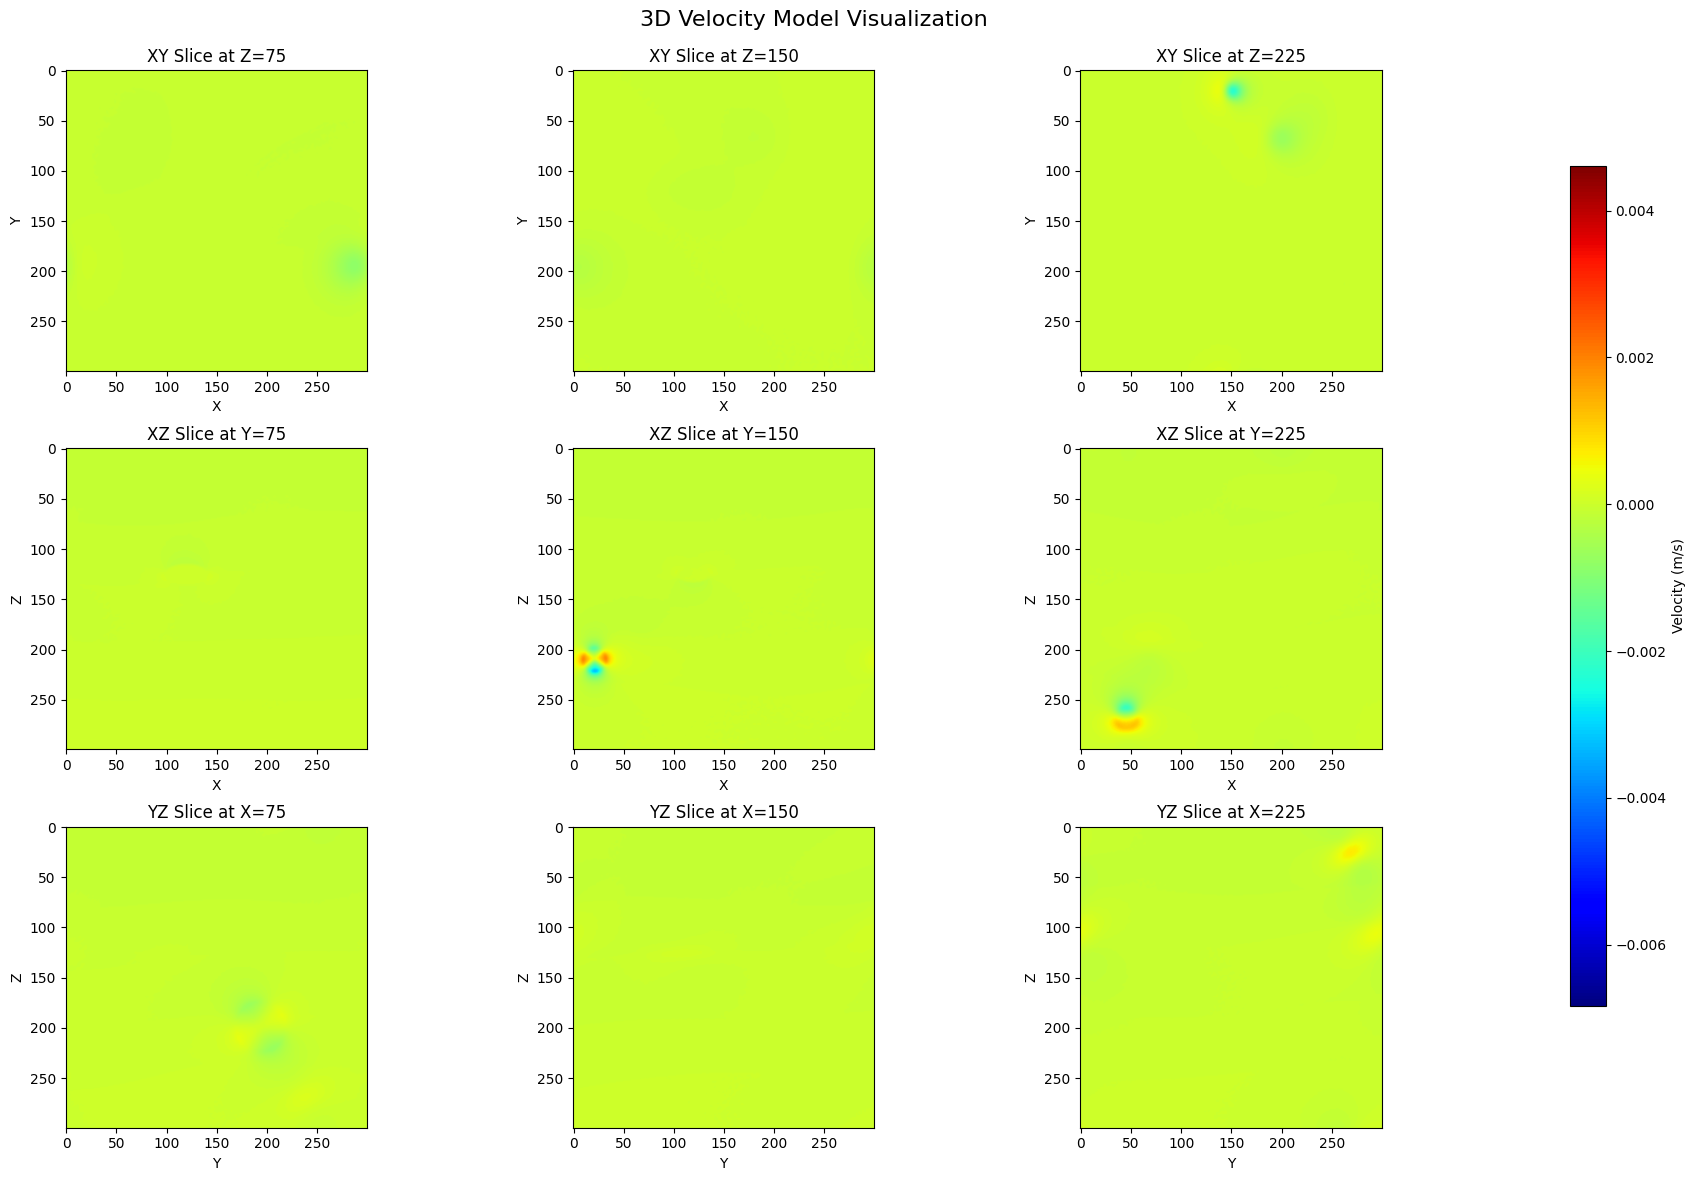

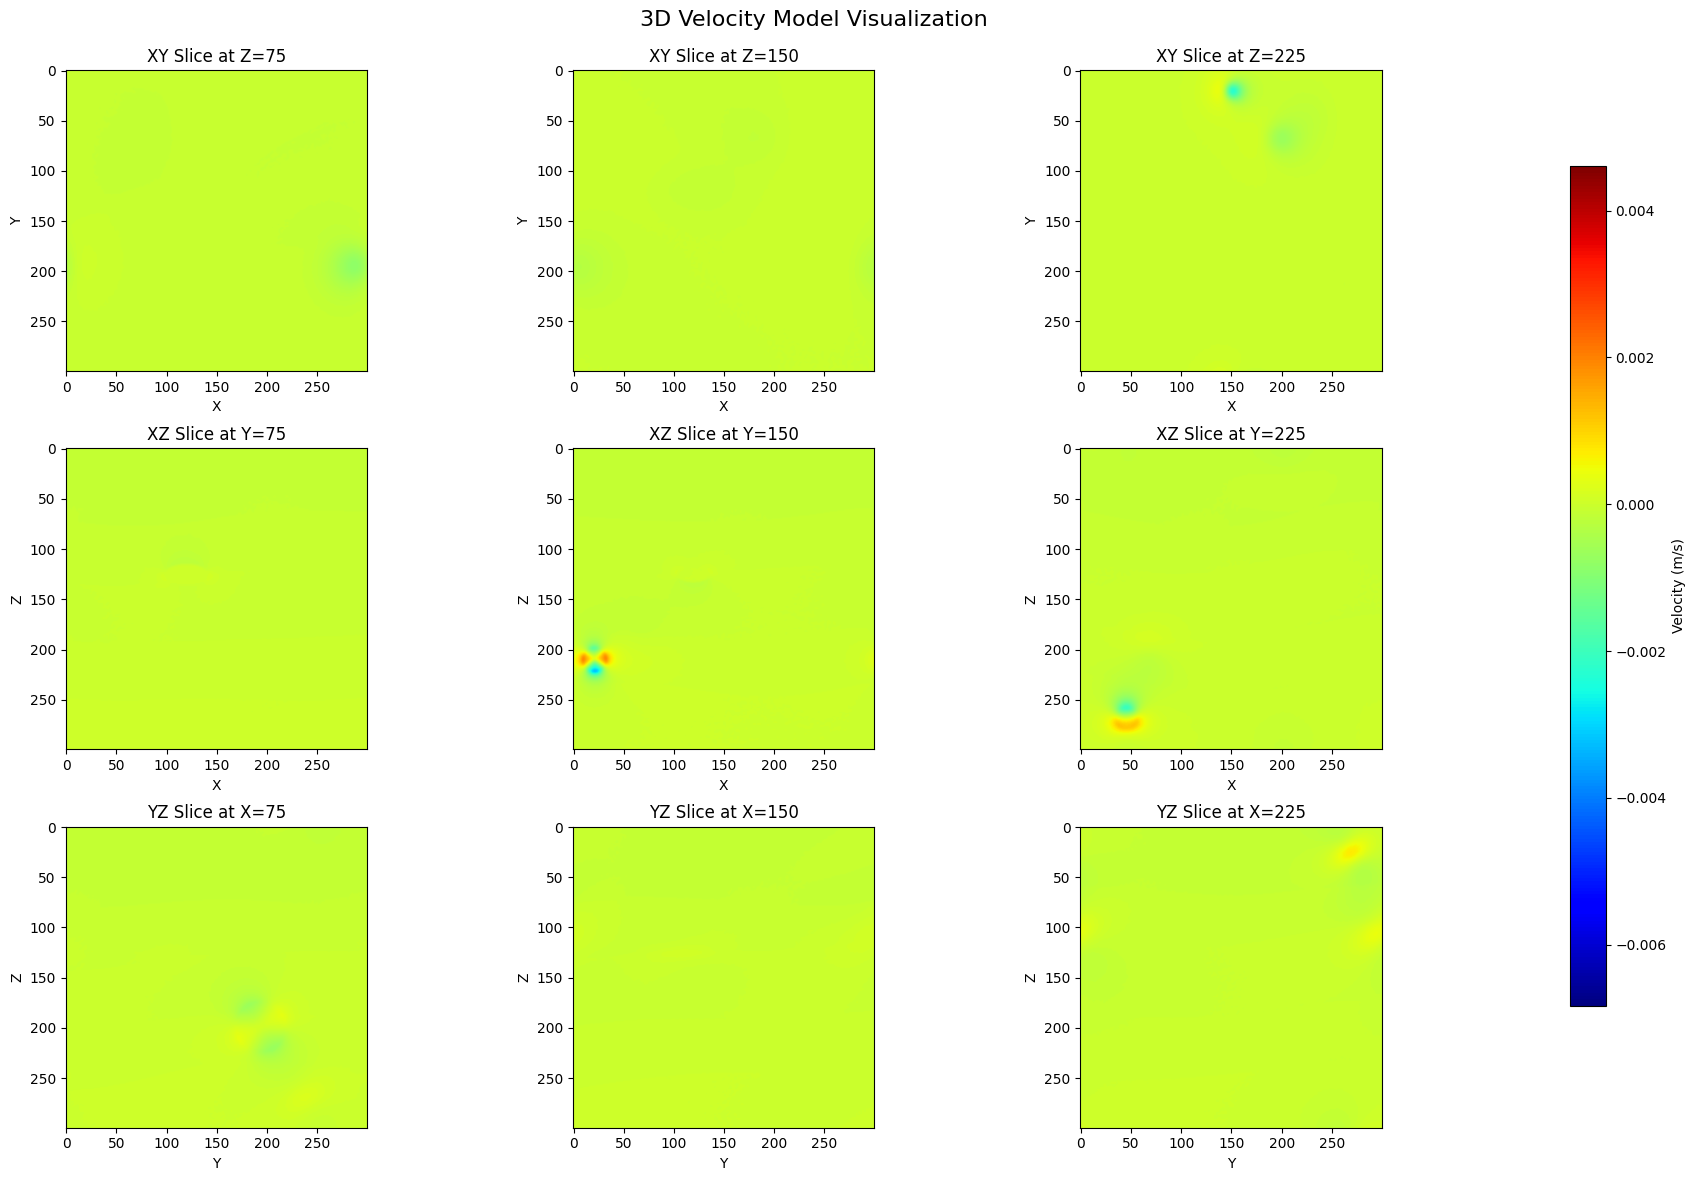

In [20]:
#@title 3D velocity model visulization
import matplotlib.pyplot as plt
import numpy as np
def visualize_model_comprehensive(velocity_model, save_pdf=False, filename=f_path+"magnetic_model_visualization_seed0.pdf"):
    """
    Comprehensive visualization of 3D velocity model with multiple views

    Parameters:
    -----------
    velocity_model : torch.Tensor
        The 3D velocity model to visualize
    save_pdf : bool, optional
        Whether to save the figure as PDF (default: False)
    filename : str, optional
        Name of the PDF file to save (default: "velocity_model_visualization.pdf")

    Returns:
    --------
    fig : matplotlib.figure.Figure
        The figure object
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.colors import Normalize

    # Convert to numpy
    vel = velocity_model.cpu().numpy()
    nx, ny, nz = vel.shape

    # Create figure
    fig = plt.figure(figsize=(18, 12))

    # Define colormap and normalization
    cmap = plt.cm.jet
    norm = Normalize(vmin=vel.min(), vmax=vel.max())

    # 1. XY slices at different depths
    depths = [nz//4, nz//2, 3*nz//4]
    for i, depth in enumerate(depths):
        ax = fig.add_subplot(3, 3, i+1)
        im = ax.imshow(vel[:, :, depth], cmap=cmap, norm=norm)
        ax.set_title(f'XY Slice at Z={depth}')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')

    # 2. XZ slices at different Y positions
    y_positions = [ny//4, ny//2, 3*ny//4]
    for i, y_pos in enumerate(y_positions):
        ax = fig.add_subplot(3, 3, i+4)
        im = ax.imshow(vel[:, y_pos, :].T, cmap=cmap, norm=norm)
        ax.set_title(f'XZ Slice at Y={y_pos}')
        ax.set_xlabel('X')
        ax.set_ylabel('Z')

    # 3. YZ slices at different X positions
    x_positions = [nx//4, nx//2, 3*nx//4]
    for i, x_pos in enumerate(x_positions):
        ax = fig.add_subplot(3, 3, i+7)
        im = ax.imshow(vel[x_pos, :, :].T, cmap=cmap, norm=norm)
        ax.set_title(f'YZ Slice at X={x_pos}')
        ax.set_xlabel('Y')
        ax.set_ylabel('Z')

    # Add colorbar
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label('Velocity (m/s)')

    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.suptitle('3D Velocity Model Visualization', fontsize=16)
    plt.subplots_adjust(top=0.93)

    # Save figure as PDF if requested
    if save_pdf:
        plt.savefig(filename, format='pdf', bbox_inches='tight', dpi=300)
        print(f"Figure saved as '{filename}'")

    plt.show()

    return fig


# Visualize the model
visualize_model_comprehensive(torch.from_numpy(magnetic_data),save_pdf=True,filename=f_path+"magnetic_model_visualization_seed0.pdf")
